# PV-IN KCNC2 Kv3.2 A new genetic cause of childhood epilepsy


## imports and config

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import platform

from pathlib import Path
from functools import lru_cache
from itertools import product
from neuron import h
from neuron import gui
from tqdm import tqdm
from typing import Iterable, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

from nrnutils import Section, Mechanism

from src.cells.pv_nrn import get_pv, get_pv_params, set_nrn_prop, mut, set_relative_prop

from src.constants import *
from src.settings import *
from src.data import get_cached_df, get_file_path, set_cache_root, get_cache_root, wide_to_long, concise_df
from src.measure import get_max_propagation, get_ap_times, calculate_failures
from src.run import get_trace
from src.utils import get_key, str_to_tuple, nearest_idx, nearest_value, nearest_idx_val, get_last_sec
from src.vis import plot_voltage_trace, set_default_style, save_fig, get_pulse_times, get_pulse_xy
from src.nrn_helpers import init_nrn, env_var, remove_cell_from_neuron

logging.basicConfig(level=logging.INFO)

for logger in ["fontTools"]:
    logging.getLogger(logger).setLevel(logging.WARNING)

if platform.system() == 'Windows':
    set_cache_root("E:\\.cache\\pv-kcnc2")

init_nrn(celsius=34, v_init=-80) # as in BBP optimisation

h.check_simulator() # method from PV_template.hoc that checks if parameters used during optimisation are the same as those used during simulation

set_default_style()

INFO:nrn_helpers:there were changes in the mod file directory
INFO:nrn_helpers:celsius=34.0 and v_init=-80.0


## Read tau activation/deactivation data

In [2]:
tau_df = pd.read_csv(get_file_path("new_tau", "data", ext="csv")).infer_objects()
tau_df

,Potential (mV),tau (ms),SE,group,tau type
0,0,21.9941,7.3705,WT,activation
1,5,17.2809,3.0450,WT,activation
2,10,11.9631,1.8886,WT,activation
3,15,6.1667,1.0859,WT,activation
4,20,5.5252,0.7765,WT,activation
...,...,...,...,...,...
65,10,42.6566,10.0340,C125Y,deactivation
66,15,52.7966,12.4200,C125Y,deactivation
67,20,52.4010,14.8260,C125Y,deactivation
68,25,66.2599,17.7360,C125Y,deactivation


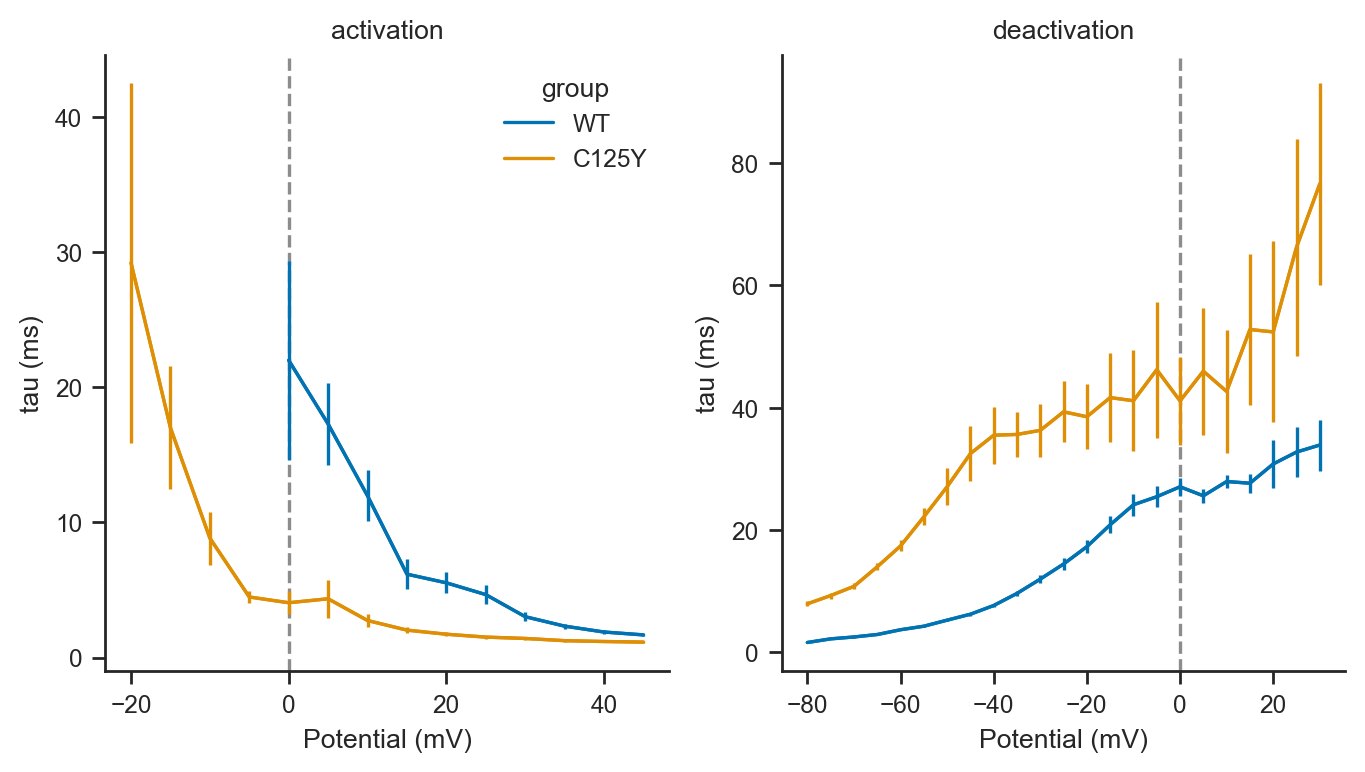

In [3]:
tau_types = tau_df["tau type"].unique()

fig, axes = plt.subplot_mosaic([list(tau_types)], figsize=(8, 4))  # type: ignore
axes: dict[str, plt.Axes]

for i, tau_type in enumerate(tau_types):
    tau_type_df = tau_df[tau_df["tau type"] == tau_type]
    ax = axes[tau_type]

    # add error bars from "SE" column
    for group in tau_type_df["group"].unique():
        tau_wt_df = tau_type_df[tau_type_df["group"] == group]
        ax.errorbar(
            tau_wt_df["Potential (mV)"], tau_wt_df["tau (ms)"], yerr=tau_wt_df["SE"]
        )
    
    # draw lines themselves
    sns.lineplot(
        data=tau_type_df,
        x="Potential (mV)",
        y="tau (ms)",
        hue="group",
        ax=ax,
        legend=bool(i == 0),  # type: ignore
    )
    ax.set_title(tau_type)
    ax.axvline(0, ls="--", color="k", alpha=0.5, zorder=-1)
# ax.spines['left'].set_position(('data', 0))


### Helpful functions for calculating currents and time constants

In [4]:
def calc_tail_current(ik_np: np.ndarray, t_np: np.ndarray, vclamp: h.SEClamp):
    """
    Calculates tail current for a given vclamp value
    """
    tail_current = np.mean(
        ik_np[
            (t_np > (vclamp.dur2 + vclamp.dur1))
            & (t_np < (vclamp.dur2 + vclamp.dur1 + 10))
        ]
    )
    return tail_current


def calc_activation_time_constant_tau(
    ik_np: np.ndarray, t_np: np.ndarray, vclamp: h.SEClamp
):
    """
    Calculates activation time constant for a given vclamp value
    """
    rise_idx = np.where((t_np > vclamp.dur1) & (t_np < (vclamp.dur2 + vclamp.dur1)))[0]
    activation_ik = ik_np[rise_idx]

    # find idx for 1-1/e of max
    idx = nearest_idx(activation_ik, activation_ik[-1] * (1 - np.exp(-1)))
    return t_np[rise_idx[0] + idx] - t_np[rise_idx[0]]


def calc_deactivation_time_constant_tau(
    ik_np: np.ndarray, t_np: np.ndarray, vclamp: h.SEClamp
):
    """
    Calculates deactivation time constant for a given vclamp value

    Example

    ..plot::

        plt.figure()
        plt.plot(
            t_np[decay_idx][int(0.5 // h.dt) :] - t_np[decay_idx[0]],
            ik_np[decay_idx][int(0.5 // h.dt) :],
            lw=1,
            c="r",
        )
        idx = nearest_idx(tail_ik_np_range, tail_ik_np_range[t_idx] * np.exp(-1))
        plt.plot(
            t_np[decay_idx[0]+ idx] - t_np[decay_idx[0]],
            ik_np[decay_idx[0]+ idx],
            "kx",
        )
        plt.suptitle(f"{t_np[decay_idx[0] + idx] - t_np[decay_idx[0]]}")
        plt.savefig("tmp.jpg", facecolor="w")

    """
    decay_idx = np.where(
        (t_np > (vclamp.dur2 + vclamp.dur1))
        & (t_np <= (vclamp.dur2 + vclamp.dur1 + vclamp.dur3))
    )[0]
    # find idx for 1/e of max
    tail_ik_np = ik_np[decay_idx]
    t_idx = int(0.5//h.dt) # slight delay (in ms, converted to index) to check for decay

    tail_ik_np_range = np.abs(tail_ik_np - tail_ik_np[-1])

    idx = nearest_idx(tail_ik_np_range, tail_ik_np_range[t_idx] * np.exp(-1))
        
    return t_np[decay_idx[0] + idx] - t_np[decay_idx[0]]

def interpolate(points: pd.DataFrame, step_size: float) -> pd.DataFrame:
    """
    Interpolate a point in a line.
    """
    interp_points = points.reindex(index=np.arange(points.index.min(), points.index.max()+1, step_size))
    interp_points = interp_points.interpolate(method="linear", limit_direction="both")
    assert interp_points is not None
    return interp_points


def find_v_half(points: pd.DataFrame):

    # find v 1/2 point for peak ik
    idx = nearest_idx(points["peak ik"].values, points["peak ik"].max()/2)
    v_half_peak = points.iloc[idx]["v"]
    return idx, v_half_peak



tau=3.04 | popt[2]=1.67
tau=2.32 | popt[2]=0.86
tau=1.92 | popt[2]=0.89
tau=2.16 | popt[2]=0.90
tau=3.68 | popt[2]=1.24
tau=4.08 | popt[2]=1.53
tau=2.56 | popt[2]=1.18
tau=2.48 | popt[2]=1.50
tau=2.72 | popt[2]=1.51
tau=2.64 | popt[2]=1.65
tau=3.60 | popt[2]=1.83
tau=3.36 | popt[2]=2.83
tau=4.64 | popt[2]=3.39
tau=1.92 | popt[2]=2.00
tau=3.92 | popt[2]=2.78
tau=4.72 | popt[2]=3.17
tau=4.96 | popt[2]=3.77
tau=6.08 | popt[2]=4.59
tau=6.80 | popt[2]=5.44
tau=7.84 | popt[2]=6.50
tau=9.28 | popt[2]=7.89
tau=10.64 | popt[2]=9.47
tau=12.40 | popt[2]=11.14
tau=14.72 | popt[2]=13.34
tau=17.84 | popt[2]=16.66
tau=19.44 | popt[2]=18.39
tau=21.68 | popt[2]=21.25
tau=22.72 | popt[2]=22.10
tau=21.60 | popt[2]=22.07
tau=22.72 | popt[2]=21.29
tau=23.68 | popt[2]=23.48
tau=21.68 | popt[2]=19.96
tau=19.92 | popt[2]=19.63
tau=24.88 | popt[2]=21.72
tau=24.56 | popt[2]=22.80


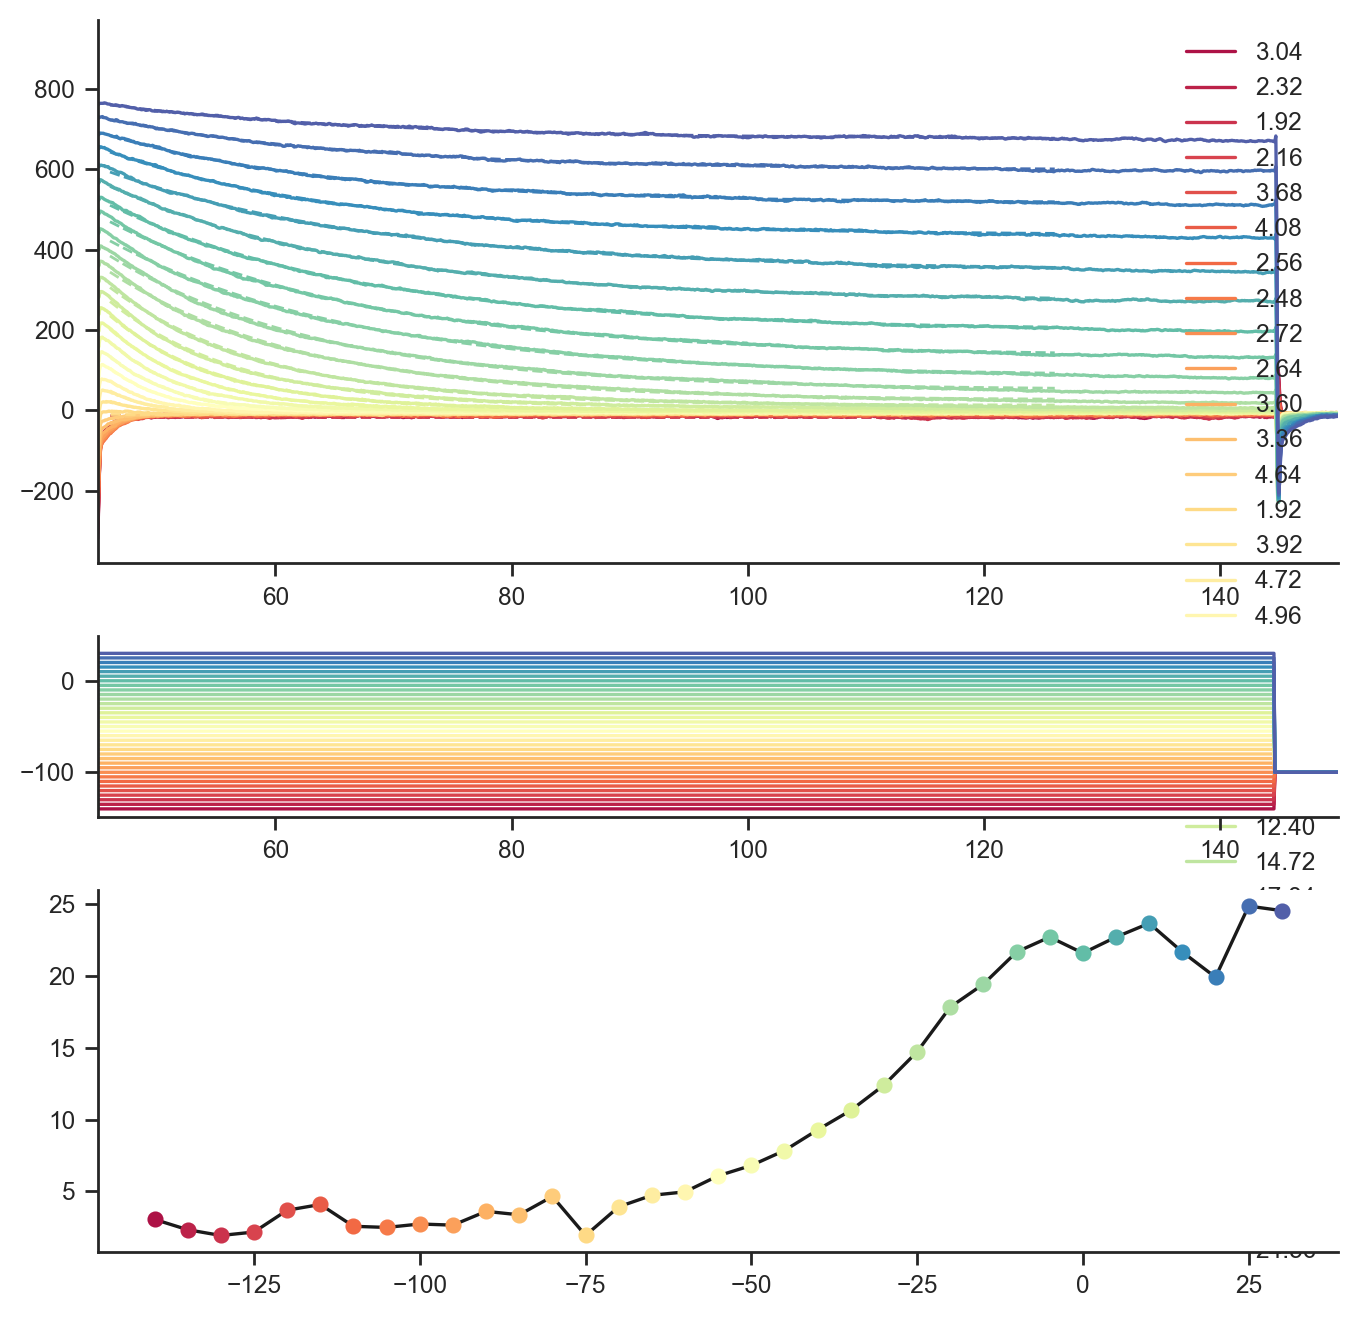

[(-140.0,
  -6.7138671875,
  -0.5675838980810245,
  1.6652887302956116,
  -14.728923420282241),
 (-135.0,
  -7.32421875,
  -9.233678330248274,
  0.8641095231663407,
  -12.693605230368506),
 (-130.0,
  -9.765625,
  -22.472363350520986,
  0.8904686778321502,
  -15.474642579192889),
 (-125.0,
  -17.176154399402623,
  46.682186447443684,
  0.8976125377141219,
  -13.115728918824741),
 (-120.0,
  -50.610636667454834,
  45.63471603248315,
  1.2413744030216032,
  -12.757674804860189),
 (-115.0,
  -47.07725817659868,
  45.58114847838382,
  1.5348961501130605,
  -10.091196187589773),
 (-110.0,
  -46.52357332549785,
  45.97832538850555,
  1.1811684241697904,
  -11.14985502086457),
 (-105.0,
  -19.132208586226533,
  47.37051778963658,
  1.4997960313573462,
  -10.57173865822077),
 (-100.0,
  -40.298269018807154,
  46.18375487332543,
  1.5108420768998543,
  -9.152960465001808),
 (-95.0,
  -6.712153904089844,
  48.99020057701477,
  1.6457177448945002,
  -8.295460881879697),
 (-90.0,
  -6.783634176721

In [5]:
import pyabf
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exp_func_to_fit(x, a, b, c, d):
    return a*np.exp(-1*(x-b)/c)+d

abf = pyabf.ABF("data/4758.abf")
# abf.headerLaunch()
fig, axes = plt.subplots(nrows=3, gridspec_kw={"height_ratios": [3, 1,2]}, figsize=(8, 8))
sns.set_palette("Spectral", n_colors=len(abf.sweepList))
dummy_seg = Section(0.1, 0.05, name="dummy_seg")
vclamp_dummy = h.SEClamp(dummy_seg(0.5))
vclamp_dummy.dur1 = 10
vclamp_dummy.dur2 = 36
vclamp_dummy.dur3 = 80
taus = []
infos = []
pal = sns.color_palette("Spectral", n_colors=len(abf.sweepList))

for i in abf.sweepList:
    abf.setSweep(i)
    t_np = abf.sweepX*1000
    decay_idx = np.where(
        (t_np > (vclamp_dummy.dur2 + vclamp_dummy.dur1))
        & (t_np <= (vclamp_dummy.dur2 + vclamp_dummy.dur1 + vclamp_dummy.dur3))
    )[0]
    popt, pcov = curve_fit(
        exp_func_to_fit,
        t_np[decay_idx],
        abf.sweepY[decay_idx],
        p0=[np.max(abf.sweepY[decay_idx]),0.1,2,np.min(abf.sweepY[decay_idx])],
        bounds=([-np.inf,-np.inf,0,-np.inf],[np.inf,np.inf,100,np.inf])
    )
    # taus.append(tau)
    if np.isinf(pcov[0,0]):
        continue
    infos.append((abf.sweepC[decay_idx][0], *popt))
    tau = popt[2]
    tau = calc_deactivation_time_constant_tau(abf.sweepY, abf.sweepX*1000, vclamp_dummy)
    print(f"{tau=:.2f} | {popt[2]=:.2f}")
    taus.append((abf.sweepC[decay_idx][0], tau))
    
    axes[0].plot(abf.sweepX*1000, abf.sweepY, label=f"{tau:.2f}", c=pal[i])
    axes[1].plot(abf.sweepX*1000, abf.sweepC, c=pal[i])
    axes[0].plot(t_np[decay_idx], exp_func_to_fit(t_np[decay_idx], *popt), ls="--", lw=1, c=pal[i])

axes[0].legend()
axes[0].set_xlim(45,150)
axes[1].set_xlim(45,150)

axes[-1].plot(*zip(*taus), "k-")
for i, (v, tau) in enumerate(taus):
    axes[-1].plot(v, tau, "o", c=pal[i])
# axes[0].set_ylim(0,400)
plt.show()
infos

## Point neurons

In [6]:
mech_type = "Kv3"

mech_type_options = ("Kv3", "SKv3_1")

assert mech_type in mech_type_options


In [7]:
# Define the model

# define ion channel parameters
leak = Mechanism("pas", e=-35, g=1e-5)
leak_mut = Mechanism("pas", e=-65, g=1e-5)
# uses ek and has param gmax

if mech_type == "Kv3":
    kv3 = Mechanism("Kv3", gmax=0.005)
    kv3_mut = Mechanism("Kv3m", gmax=0.005)
else:
    kv3 = Mechanism("SKv3_1", gSKv3_1bar=0.005)
    kv3_mut = Mechanism("SKv3_1m", gSKv3_1bar=0.005)

is_inactivating = kv3.name == "Kv3"

props = dict(L=30, diam=15, nseg=3, cm=1)
passive_point_neuron = ppn = Section(**props, mechanisms=[leak, kv3], name="WT")
passive_point_neuron_mutant = ppn_mut = Section(
    **props, mechanisms=[leak_mut, kv3_mut], name="C125Y"
)

# change property without creating new neurons/mechanisms
def set_seg_prop(nrn: Section, prop: str, value: float):
    for seg in nrn:
        setattr(seg, prop, value)


def change_mech_props(nrn: Section, mech="SKv3_1", **prop_value_dict):
    for seg in nrn:
        for prop, value in prop_value_dict.items():
            setattr(getattr(seg, mech), prop, value)


set_seg_prop(ppn, "ek", -60)
set_seg_prop(ppn_mut, "ek", -120)

# Objects
t_vec = h.Vector()
v = h.Vector()
v_mut = h.Vector()
ik = h.Vector()
ik_mut = h.Vector()

# record
t_vec.record(h._ref_t)  # only once a section is created
v.record(ppn(0.5)._ref_v)
v_mut.record(ppn_mut(0.5)._ref_v)
ik.record(ppn(0.5)._ref_ik)
ik_mut.record(ppn_mut(0.5)._ref_ik)
vclamp = h.SEClamp(ppn(0.5))
vclamp_mut = h.SEClamp(ppn_mut(0.5))

v_init = env_var()["v_init"]
vclamp.dur1 = vclamp_mut.dur1 = 10
vclamp.dur2 = vclamp_mut.dur2 = 100
vclamp.dur3 = vclamp_mut.dur3 = 100
vclamp.amp1 = vclamp_mut.amp1 = v_init
vclamp.amp2 = vclamp_mut.amp2 = v_init  # this will be changed by the code later
vclamp.amp3 = vclamp_mut.amp3 = -40
vclamp.rs = vclamp_mut.rs = 0.01

str(ppn)


"Section(L=30.0, Ra=100.0, nseg=3, rallbranch=1.0, diam=15.0, cm=1.0, mechanisms=[Mechanism(name=pas, parameters={'e': -35, 'g': 1e-05}),Mechanism(name=Kv3, parameters={'gmax': 0.005})], synapses=[], parent=_)"

### Voltage clamp IV curve

In [8]:
def iv_fig(
    vclamp_values=None,
    vclamp_target="amp2",
    ppn_props=None,
    ppn_mut_props=None,
    tstop=210,
    extended=False,
):
    """
    Plots IV curve for the ppn and ppn_mut point neurons.

    **Note** that ppn_props permantly changes the properties of the ppn point neuron.

    """
    if vclamp_values is None:
        vclamp_values = np.arange(-65, 50, 5)
    ppn_props = ppn_props or {}
    ppn_mut_props = ppn_mut_props or {}

    h.tstop = max(tstop, vclamp.dur1 + vclamp.dur2 + vclamp.dur3)

    points = pd.DataFrame()

    # only initial vclamp_values will be plotted, but simulations will be run for these values
    if extended:
        extended_vclamp_values = np.arange(vclamp_values.min(), vclamp_values.max() + 1, 1)
    else:
        extended_vclamp_values = vclamp_values

    if is_inactivating:
        # check if ppn_props is empty
        if ppn_props or ppn_mut_props:
            h.usetable_Kv3 = 0
            h.usetable_Kv3m = 0
        else:
            h.usetable_Kv3 = 1
            h.usetable_Kv3m = 1
        change_mech_props(ppn, "Kv3", **ppn_props)
        change_mech_props(ppn_mut, "Kv3m", **ppn_mut_props)
    else:
        change_mech_props(ppn, "SKv3_1", **ppn_props)
        change_mech_props(ppn_mut, "SKv3_1m", **ppn_mut_props)

    sample_lines = {
        "v": [],
        "ik": [],
        "ik_mut": [],
    }

    tau_calc_meth = (
        calc_activation_time_constant_tau
        if vclamp_target == "amp2"
        else calc_deactivation_time_constant_tau
    )
    tau_key = "tau activation" if vclamp_target == "amp2" else "tau deactivation"

    for amp in tqdm(extended_vclamp_values):
        setattr(vclamp, vclamp_target, amp)
        setattr(vclamp_mut, vclamp_target, amp)
        # vclamp.amp2 = vclamp_mut.amp2 = amp

        h.finitialize(env_var()["v_init"])
        h.run()

        t_np = t_vec.as_numpy()
        v_np = v.as_numpy()
        ik_np = ik.as_numpy()
        v_mut_np = v_mut.as_numpy()
        ik_mut_np = ik_mut.as_numpy()

        if amp in vclamp_values:
            sample_lines["v"].append(np.array(v_np))  # copy data
            sample_lines["ik"].append(np.array(ik_np))
            sample_lines["ik_mut"].append(np.array(ik_mut_np))

        points = pd.concat(
            [
                points,
                pd.DataFrame(
                    {
                        "v target": vclamp_target,
                        "v": [amp, amp],
                        "peak ik": [max(ik_np), max(ik_mut_np)],
                        "tail ik": [
                            calc_tail_current(ik_np, t_np, vclamp),
                            calc_tail_current(ik_mut_np, t_np, vclamp_mut),
                        ],
                        tau_key: [
                            tau_calc_meth(ik_np, t_np, vclamp),
                            tau_calc_meth(ik_mut_np, t_np, vclamp_mut),
                        ],
                        "Kv3.2": [ppn.name(), ppn_mut.name()],
                    },
                    # index=[0, 1], # only needed if single row
                ),
            ],
            ignore_index=True,
        )

    # clean up dataframe
    # convert ik in mA/cm2 to pA/pF using membrane capacitance (uF/cm2)
    points["peak ik"] = points["peak ik"] * 1e3 / ppn.cm
    points["tail ik"] = points["tail ik"] * 1e3 / ppn.cm

    return points, sample_lines

100%|██████████| 16/16 [00:00<00:00, 22.79it/s]


(<Figure size 1600x1200 with 6 Axes>,
 {'ik': <AxesSubplot: label='ik', title={'center': 'WT'}>,
  'ik_mut': <AxesSubplot: label='ik_mut', title={'center': 'C125Y'}>,
  'i-v peak': <AxesSubplot: label='i-v peak', title={'center': 'Peak current density'}, xlabel='Voltage (mv)', ylabel='$\\rm{I_{K}}$ (pA/pF)'>,
  'i-v tail': <AxesSubplot: label='i-v tail', title={'center': 'Tail current'}, xlabel='Voltage (mv)'>,
  'tau activation': <AxesSubplot: label='tau activation', title={'center': 'Activation'}, xlabel='Voltage (mv)', ylabel='$\\tau$ (ms)'>,
  'tau deactivation': <AxesSubplot: label='tau deactivation', title={'center': 'Deactivation'}, xlabel='Voltage (mv)'>,
  'v': <Axes: label='inset_axes'>})

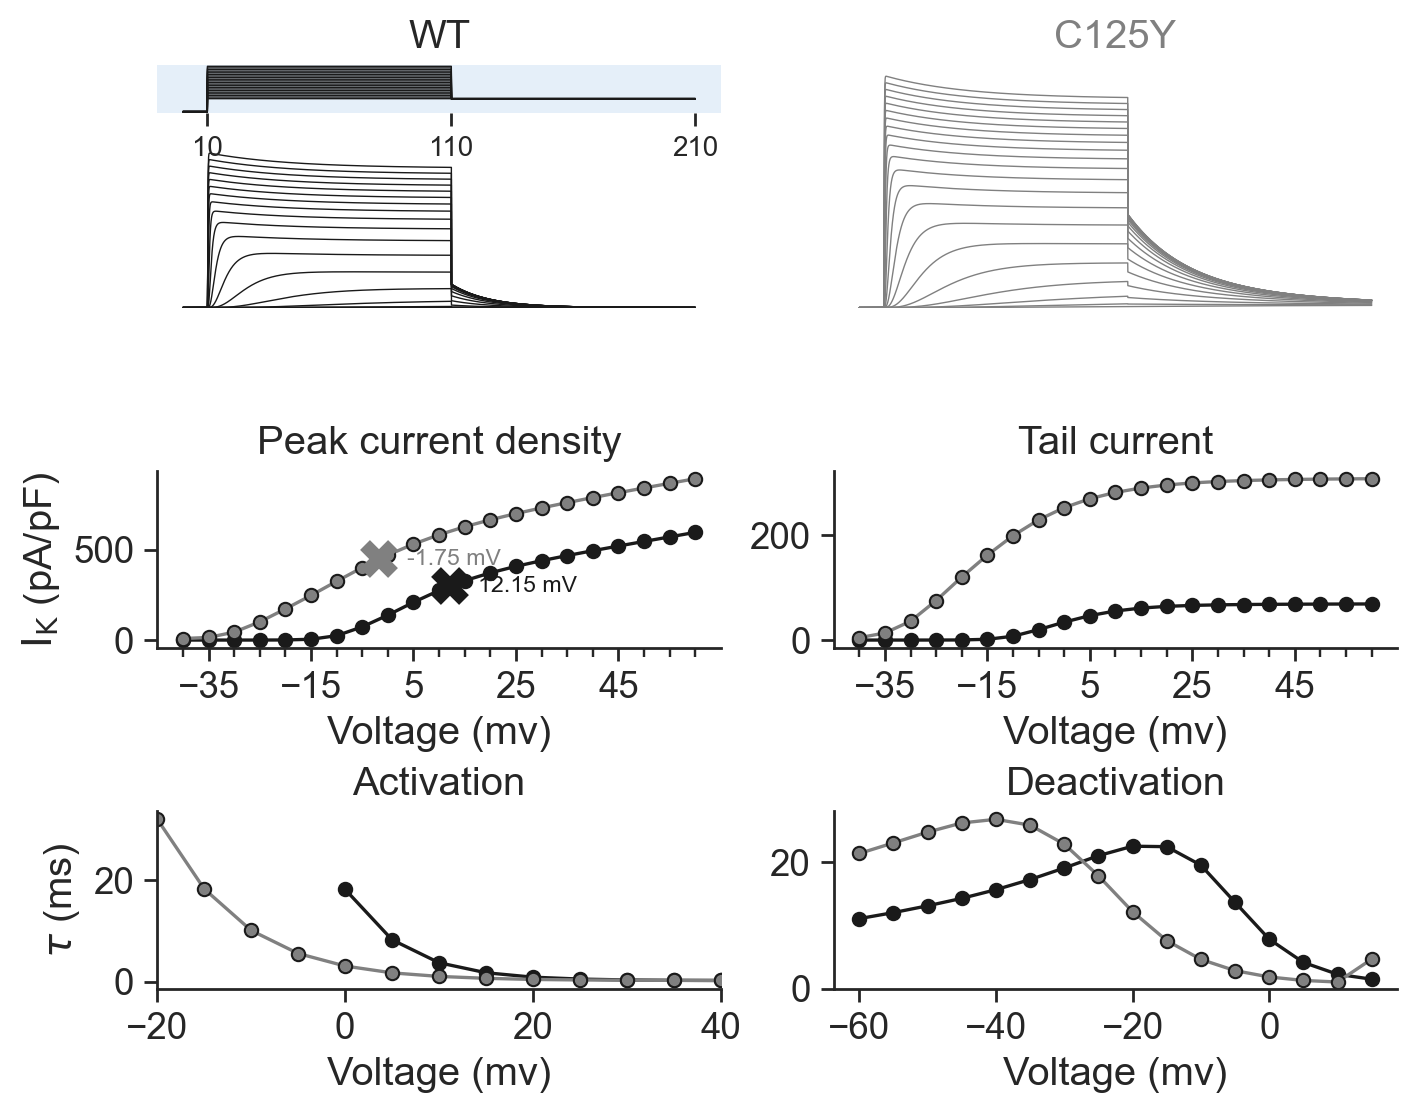

In [9]:
ppn_props = dict(
    theta_m=-13.0,
    k_m=7.8,
    tau_m0=0.1,
    tau_m1=80.0,
    phi_m0=-20.0,
    phi_m1=-13.0,
    sigma_m0=60.0,
    sigma_m1=-6.0,
)
ppn_mut_props = dict(
    theta_m=-35.0,
    k_m=12,
    tau_m0=0.1,
    tau_m1=60,
    phi_m0=-80.0,
    phi_m1=-30.0,
    sigma_m0=100.0,
    sigma_m1=-8.0,
)

# create a hashable dict for use with lru_cache
class hashabledict(dict):
    def __key(self):
        return tuple((k, self[k]) for k in sorted(self))

    def __hash__(self):
        return hash(self.__key())

    def __eq__(self, other):
        return self.__key() == other.__key()


@lru_cache
def run_iv_figs(ppn_props: hashabledict, ppn_mut_props: hashabledict):
    ## Activation curve - step currents

    # Vclamp parameters
    vclamp.amp1 = vclamp_mut.amp1 = v_init
    vclamp.amp2 = vclamp_mut.amp2 = v_init  # this will be changed by the code later
    vclamp.amp3 = vclamp_mut.amp3 = -40

    vclamp_values = np.arange(-40, 65, 5)

    points, sample_lines = iv_fig(
        vclamp_values,
        vclamp_target="amp2",
        ppn_props=ppn_props,
        ppn_mut_props=ppn_mut_props,
    )

    ## Deactivation curve - variable step depolarisation
    # reset vclamp
    vclamp.amp1 = vclamp_mut.amp1 = -100
    vclamp.amp2 = vclamp_mut.amp2 = 20
    vclamp.amp3 = vclamp_mut.amp3 = -40  # this will now change by below

    deact_points, deact_sample_lines = iv_fig(
        np.arange(-60, 20, 5),
        vclamp_target="amp3",
        ppn_props=ppn_props,
        ppn_mut_props=ppn_mut_props,
    )

    t_np = t_vec.as_numpy().copy()

    # fig, axes = plt.subplots(nrows=4, gridspec_kw={"height_ratios": [0.1, 0.2, 1, 0.5]})

    # decay_idx = np.where(
    #     (t_np > (vclamp.dur2 + vclamp.dur1))
    #     & (t_np <= (vclamp.dur2 + vclamp.dur1 + vclamp.dur3))
    # )[0]

    # for v_line, ik_line, ik_mut_line in zip(
    #     deact_sample_lines["v"], deact_sample_lines["ik"], deact_sample_lines["ik_mut"]
    # ):
    #     axes[0].plot(t_np, v_line, c="k", alpha=0.2, zorder=-1)
    #     axes[1].plot(t_np, ik_line, c="blue", alpha=0.5)
    #     axes[1].plot(t_np, ik_mut_line, c="orange", alpha=0.5)
    #     for ik_np, c in zip([ik_line, ik_mut_line], ["blue", "orange"]):
    #         # find idx for 1/e of max
    #         tail_ik_np = ik_np[decay_idx]
    #         t_idx = int(
    #             0.5 // h.dt
    #         )  # slight delay (in ms, converted to index) to check for decay
    #         tail_ik_np_range = np.abs(tail_ik_np - tail_ik_np[-1])
    #         idx = nearest_idx(tail_ik_np_range, tail_ik_np_range[t_idx] * np.exp(-1))
    #         tau = t_np[decay_idx[0] + idx] - t_np[decay_idx[0]]

    #         axes[2].plot(
    #             t_np[decay_idx][int(0.5 // h.dt) :] - 110,
    #             ik_np[decay_idx][int(0.5 // h.dt) :],
    #             c=c,
    #             label=f"{tau:.2f}",
    #             alpha=0.5,
    #         )
    #         axes[2].plot(
    #             t_np[
    #                 decay_idx[0]
    #                 + nearest_idx(tail_ik_np_range, tail_ik_np_range[t_idx] * np.exp(-1))
    #             ]
    #             - 110,
    #             ik_np[
    #                 decay_idx[0]
    #                 + nearest_idx(tail_ik_np_range, tail_ik_np_range[t_idx] * np.exp(-1))
    #             ],
    #             "x",
    #             c=c,
    #         )

    # sns.lineplot(
    #     data=deact_points,
    #     x="v",
    #     y="tau deactivation",
    #     hue="Kv3.2",
    #     ax=axes[-1],
    #     palette=["blue", "orange"],
    # )
    # # axes[2].set_ylim(max(axes[2].get_ylim())*0.75)

    ##########
    # Figure
    ##########
    sns.set_context("paper", font_scale=1.5)

    fig, axes = plt.subplot_mosaic(
        [
            ["ik", "ik_mut"],
            ["ik", "ik_mut"],
            ["i-v peak", "i-v tail"],
            ["tau activation", "tau deactivation"],
        ],
        gridspec_kw={"height_ratios": [0.4, 0.5, 2, 2], "hspace": 1.5},
        dpi=200,
        figsize=(8, 6),
    )  # type: ignore

    axes: dict[str, plt.Axes]

    # create inset axis
    axes["v"] = axes["ik"].inset_axes([0.0, 0.8, 1.0, 0.2])

    # plot sample lines
    for key in sample_lines.keys():
        c = "gray" if "mut" in key else "k"
        for i, line in enumerate(sample_lines[key]):
            axes[key].plot(t_np, line, lw=0.5, c=c)

    # take only vclamp values
    plot_points = points[points["v"].isin(vclamp_values)]

    VOLTAGE_MV = "Voltage (mv)"

    sns.lineplot(
        data=plot_points,
        x="v",
        y="peak ik",
        ax=axes["i-v peak"],
        hue="Kv3.2",
        palette=["k", "gray"],
        marker="o",
        markeredgecolor="k",
        legend=False,
    )
    sns.lineplot(
        data=plot_points,
        x="v",
        y="tail ik",
        ax=axes["i-v tail"],
        hue="Kv3.2",
        palette=["k", "gray"],
        marker="o",
        markeredgecolor="k",
        legend=False,
    )

    # plot voltage at half peak
    for key, c in zip(["WT", "C125Y"], ["k", "gray"]):
        df_kv = points[points["Kv3.2"] == key].reset_index()
        interp_points = interpolate(df_kv, 0.01)
        df_kv["Relative conductance"] = df_kv["peak ik"] / df_kv["peak ik"].max()
        interp_points["Relative conductance"] = (
            interp_points["peak ik"] / interp_points["peak ik"].max()
        )

        v_half_idx, v_half = find_v_half(interp_points)
        # print(f"{v_half=}")
        xy = (v_half, interp_points.iloc[v_half_idx]["peak ik"])
        axes["i-v peak"].annotate(
            f"{xy[0]:.2f} mV",
            xy=xy,
            xytext=(10, 0),
            textcoords="offset points",
            color=c,
            # arrowprops=dict(arrowstyle="->", color="k"),
            va="center",
            fontsize="xx-small",
        )

        axes["i-v peak"].plot(
            *xy, "x", color=c, markersize=10, markeredgewidth=5, zorder=100
        )

    axes["v"].set_ylim(env_var()["v_init"] - 5, max(vclamp_values) + 5)
    # set ylims the same for ik and ikmut
    ymax = max(axes["ik"].get_ylim()[1], axes["ik_mut"].get_ylim()[1])
    for ax in [axes["ik"], axes["ik_mut"]]:
        ax.set_ylim(0, ymax)

    axes["ik"].set_title(ppn.name())
    axes["ik_mut"].set_title(ppn_mut.name(), color="gray")

    axes["i-v peak"].set_title("Peak current density")
    axes["i-v tail"].set_title("Tail current")

    for ax in [axes["v"], axes["ik"], axes["ik_mut"]]:
        sns.despine(ax=ax, left=True, bottom=True)
        ax.set(yticks=[], xticks=[])

    xticks = [
        vclamp.dur1,
        vclamp.dur1 + vclamp.dur2,
        vclamp.dur1 + vclamp.dur2 + vclamp.dur3,
    ]
    axes["v"].set_xticks(xticks)
    axes["v"].set_xticklabels(np.array(xticks, dtype=int), fontsize="x-small")

    # sns.despine(ax=axes["v"], top=False, right=False)
    pal = sns.color_palette("Blues", n_colors=10)
    axes["v"].set_facecolor(pal[0])

    for ax in [axes["i-v peak"], axes["i-v tail"]]:
        ax.set_xlabel(VOLTAGE_MV)
        if ax == axes["i-v peak"]:
            ax.set_ylabel("$\\rm{I_{K}}$ (pA/pF)")
        else:
            ax.set_ylabel("")
        ax.set_xticks(plot_points["v"], minor=True)
        ax.set_xticks(
            np.arange(vclamp_values.min() + 5, vclamp_values.max() + 5, 20), minor=False
        )

    for i, key in enumerate(["tau activation", "tau deactivation"]):
        if "deactivation" in key:
            tau_plot_points = deact_points[
                (deact_points["v"] >= -60) & (deact_points["v"] <= 30)
            ]
        else:
            tau_plot_points = plot_points[
                (
                    ((plot_points["v"] >= 0) & (plot_points["Kv3.2"] == "WT"))
                    | ((plot_points["v"] >= -20) & (plot_points["Kv3.2"] == "C125Y"))
                )
            ]

        sns.lineplot(
            data=tau_plot_points,
            x="v",
            y=key,
            ax=axes[key],
            hue="Kv3.2",
            hue_order=["WT", "C125Y"],
            palette=["k", "gray"],
            marker="o",
            markeredgecolor="k",
            legend=False,
        )
        axes[key].set_title(key.replace("tau ", "").capitalize())
        axes[key].set_xlabel(VOLTAGE_MV)
        if key == "tau activation":
            axes[key].set_ylabel(f"$\\tau$ (ms)")
        else:
            axes[key].set_ylabel("")

    axes["tau activation"].set_xlim(-20, 40)
    axes["tau deactivation"].set_ylim(0)
    # axes["tau deactivation"].set_yticks([0, 10, 20, 30, 40, 60])
    return fig, axes


run_iv_figs(hashabledict(ppn_props), hashabledict(ppn_mut_props))


In [ ]:
%matplotlib inline
# Widgets
from IPython.display import clear_output

set_seg_prop(ppn, "ek", -120)
set_seg_prop(ppn_mut, "ek", -120)

# ppn_props = dict(iv_shift=-2.11, iv_gain=-9.7, tau_scale=20, tau_shift=10.0, tau_gain=8)
# ppn_mut_props = dict(iv_shift=-20.0, iv_gain=-10.2, tau_scale=28, tau_shift=-10.0, tau_gain=6)

ppn_props = dict(
    theta_m=0.0,
    k_m=7.8,
    tau_m0=0.1,
    tau_m1=20.0,
    phi_m0=10.0,
    phi_m1=12.0,
    sigma_m0=100.0,
    sigma_m1=-7.0,
)

ppn_mut_props = dict(
    theta_m=-15.0,
    k_m=7.8,
    tau_m0=0.1,
    tau_m1=60.0,
    phi_m0=-12.0,
    phi_m1=-15.0,
    sigma_m0=150.0,
    sigma_m1=-8.0,
)

range_props = dict(
    theta_m=(-100, 100),
    k_m=(-5, 20),
    tau_m0=(0.1, 100),
    tau_m1=(-100, 100),
    phi_m0=(-100, 100),
    phi_m1=(-100, 100),
    sigma_m0=(-100, 400),
    sigma_m1=(-20, 0),
)
output = widgets.Output()

ppn_mut_props_orig = ppn_mut_props.copy()

def on_change(change_slider):
    with output:
        ppn_mut_props[change_slider.owner.description] = change_slider.new

        print(ppn_mut_props)

        fig, axes = run_iv_figs(hashabledict(ppn_mut_props_orig), hashabledict(ppn_mut_props))
        fig.suptitle(str(ppn_mut_props), fontsize='x-small')
        clear_output()
        display(fig)
        plt.close(fig)

# create float slider per parameter
sliders = []
for key, value in range_props.items():
    slider =widgets.FloatSlider(
            value=ppn_mut_props[key],
            min=value[0],
            max=value[1],
            step=0.1 if key in ["theta_m", "k_m", "tau_m"] else 1,
            description=key,
            continuous_update=False,
            readout=True,
            readout_format=".1f",
        )
    slider.observe(on_change, names="value") # type: ignore
    sliders.append(slider)

# add button to reset to original values
def on_reset(b):
    ppn_mut_props.update(ppn_mut_props_orig)
    with output:
        clear_output()
        for slider in sliders:
            slider: widgets.FloatSlider
            slider.value = ppn_mut_props[slider.description]
            # slider.notify_change({"name": "value", "old": None, "new": slider.value, "owner": slider})

button = widgets.Button(description="Reset")
button.on_click(on_reset)

box = widgets.VBox(sliders + [button])
display(box, output)

## PV Interneuron

In [6]:
pv = get_pv("pv")
pv
pv = get_pv("default", 1000, 30, 1, 60)
mechs = []
for sec in pv.node:
    for seg in sec:
        for mech in seg:
            mechs.append(mech.name())
        break
    break
if "Kv3" in mechs:
    mech_type = "Kv3"
elif "SKv3_1" in mechs:
    mech_type = "SKv3_1"
else:
    raise ValueError("Kv3.2 mechanism not found")

props_to_find = [
    "theta_m",
    "k_m",
    "tau_m0",
    "tau_m1",
    "phi_m0",
    "phi_m1",
    "sigma_m0",
    "sigma_m1",
]
pv_props = {}
pv_mut_props = {}
for sec in pv.node:
    for seg in sec:
        for mech in seg:
            if mech.name() == mech_type:
                for prop in props_to_find:
                    pv_props[prop] = getattr(mech, prop)
            elif mech.name() == mech_type + "m":
                for prop in props_to_find:
                    pv_mut_props[prop] = getattr(mech, prop)
        break
    break
pv_props, pv_mut_props

({'theta_m': -13.0,
  'k_m': 7.8,
  'tau_m0': 0.1,
  'tau_m1': 80.0,
  'phi_m0': -13.0,
  'phi_m1': -13.0,
  'sigma_m0': 60.0,
  'sigma_m1': -6.0},
 {'theta_m': -35.0,
  'k_m': 12.0,
  'tau_m0': 0.1,
  'tau_m1': 60.0,
  'phi_m0': -80.0,
  'phi_m1': -30.0,
  'sigma_m0': 100.0,
  'sigma_m1': -8.0})

In [ ]:

### create method for running multiple simulations
def run_sims(pv, stims, fractions, dur, load=False, arrow=False, shape_plot=True, pv_props=None, pbar_prefix=""):

    # create pv if object not passed
    # this is useful if we want to dispose of the object after the function call
    _created_pv = False
    if isinstance(pv, str):
        pv = get_pv(pv)
        _created_pv = True
    
    if pv_props is None:
        pv_props = {}
    
    # optionally set properties of pv neuron
    for key, val in pv_props.items():
        set_nrn_prop(pv, key, val, ignore_error=True)

    if pbar_prefix:
        pbar_prefix += "|>"

    # note that we 'tuple' the product generator to convert it to an iterable of known length for the progressbar
    pbar = tqdm(tuple(product(stims, fractions)), leave=pbar_prefix=="")
    
    results = {}
    
    for stim, frac in pbar:
        amp, freq = stim
        key_name = get_key(pv, frac, stim, dur)
        pbar.set_description(f"{pbar_prefix}{key_name}")

        path = get_file_path(key_name)
        long_format_path = get_file_path(key_name, ext="arrow")

        x_df = None
        if not path.exists():
            pbar.set_description(f"{pbar_prefix}{key_name} running")
            
            pv.biophys()
            mut(pv, frac)

            # run sim and save results
            AP, x_df = get_cached_df(key_name, pv, amp, dur, stim_freq=freq, shape_plot=shape_plot)

        if arrow and not long_format_path.exists():
            """Save in .feather format, to be loaded using vaex and arrow"""
            if x_df is None:
                # load results
                pbar.set_description(f"{key_name} loading")
                AP, x_df = get_cached_df(key_name)
            # format data
            long_df = wide_to_long(x_df)
            # add metadata as columns with uniform data along the rows
            long_df[KVMUT_FRAC_LABEL] = frac
            long_df[CURRENT_LABEL] = amp
            long_df["Stim. duration"] = dur
            long_df[STIM_FREQ_LABEL] = freq
            long_df["key"] = key_name
            
            for key, val in AP.items():
                if isinstance(val, list):
                    ap_val = " ".join([str(v.n) for v in val])
                else:
                    ap_val = val.n
                long_df[f"AP_{key}"] = ap_val

            for key, val in pv_props.items():
                long_df[key] = val

            # save
            pbar.set_description(f"{key_name} saving")
            long_df.to_feather(long_format_path)
        
        if load:
            if x_df is None:
                # load results
                pbar.set_description(f"{key_name} loading")
                AP, x_df = get_cached_df(key_name)
            df = wide_to_long(x_df) if x_df is not None else None
                
            # store in dict
            results[key_name] = {
                                "df": df,
                                KVMUT_FRAC_LABEL: frac,
                                CURRENT_LABEL: amp,
                                "Stim. duration": dur,
                                STIM_FREQ_LABEL: freq,
                                "APCount": AP,
                                **pv_props,
                               }

        pbar.set_description(f"{pbar_prefix}{key_name} done")

    if _created_pv:
        remove_cell_from_neuron(pv)

    return results
    

### F-I curve

In [ ]:
stims = [(amp, 0) for amp in np.round(np.arange(0.,4.1,0.1), 3)]

fractions = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.5]

amp_result = run_sims("default", stims, fractions, dur=500, load=True, arrow=False)

ap_df = pd.DataFrame()

for key, val in amp_result.items():
    nrn_name = key[: key.find("_")]
    frac = val[KVMUT_FRAC_LABEL]
    current = val[CURRENT_LABEL]
    ap_soma = val["APCount"]["soma"].n
    ap_ais = val["APCount"]["init"].n
    ap_axon = val["APCount"]["comm"].n

    ap_df = pd.concat(
        [
            ap_df,
            pd.DataFrame(
                {
                    KVMUT_FRAC_LABEL: frac,
                    CURRENT_LABEL: current,
                    "Neuron": nrn_name,
                    "loc": ["soma", "AIS", "axon"],
                    "Spikes": [ap_soma, ap_ais, ap_axon],
                },
            ),
        ],
        ignore_index=True,
    )
ap_df[FIRING_RATE_LABEL] = ap_df["Spikes"]/0.5

sns.lineplot(
    data=ap_df,
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    hue="Neuron",
    style="Neuron",
    # markers=["o", "s", "D"],
    palette="Greys_r",
    size="loc",
    size_order=["AIS"],
    
)



### Adjust Kv3.2 params

In [ ]:
mech_type

In [ ]:
stims = [(amp, 0) for amp in np.round(np.arange(0., 4.1, 0.1), 3)]

# either change params of the original Kv3.2 channel ("down") or the mutated Kv3.2 channel ("up")
mut_directions = {"up": [0.25], "down": [0]}
ppn_props = dict(
    theta_m=0.0,
    k_m=7.8,
    tau_m0=0.1,
    tau_m1=20.0,
    phi_m0=10.0,
    phi_m1=12.0,
    sigma_m0=100.0,
    sigma_m1=-7.0,
)

ppn_mut_props = dict(
    theta_m=-15.0,
    k_m=7.8,
    tau_m0=0.1,
    tau_m1=60.0,
    phi_m0=-12.0,
    phi_m1=-15.0,
    sigma_m0=150.0,
    sigma_m1=-8.0,
)

params = {}
# params (values are default -> mutant)
for key, val in ppn_mut_props.items():
    params[key] = np.round(np.linspace(ppn_props[key], val, 11), 2)

param_df = pd.DataFrame()
for mut_up_down, fracs in mut_directions.items():
    for param_key, param_space in params.items():
        if isinstance(param_key, tuple):
            actual_params = [f"{pk}_{mech_type}" for pk in param_key]
        else:
            actual_params = [f"{param_key}_{mech_type}"]

        if mut_up_down == "up":
            actual_params = [f"{p}m" for p in actual_params]
        param_name = " ".join(actual_params)

        length = len(param_space) if not np.iterable(param_space[0]) else len(param_space[0])

        for i in range(length):
            if np.iterable(param_space[0]):
                pv_props = {p: v[i] for p, v in zip(actual_params, param_space)}
            else:
                pv_props = {p: param_space[i] for p in actual_params}

            param_val = tuple(pv_props.values())
            if len(param_val) == 1:
                param_val = param_val[0]
            else:
                param_val = " ".join([str(v) for v in param_val])

            # join dict as string
            pv_key = " ".join([f"{k}={v}" for k, v in pv_props.items()])

            param_result = run_sims(
                pv_key,
                stims,
                fracs,
                dur=500,
                load=True,
                arrow=False,
                shape_plot=False, # quicker running/saving/loading but no voltage traces
                pv_props=pv_props, # change params
                pbar_prefix=f"{mut_up_down}|>{param_key}",
            )

            for key, val in param_result.items():
                nrn_name = key[: key.find("_")]
                frac = val[KVMUT_FRAC_LABEL]
                current = val[CURRENT_LABEL]
                ap_soma = val["APCount"]["soma"].n
                ap_ais = val["APCount"]["init"].n
                ap_axon = val["APCount"]["comm"].n
                
                param_df = pd.concat(
                    [
                        param_df,
                        pd.DataFrame(
                            {
                                "param": param_name,
                                "value": param_val,
                                param_key: param_val,
                                "mutation direction": mut_up_down,
                                KVMUT_FRAC_LABEL: frac,
                                CURRENT_LABEL: current,
                                "Neuron": nrn_name,
                                "loc": ["soma", "AIS", "axon"],
                                "Spikes": [ap_soma, ap_ais, ap_axon],
                            },
                        ),
                    ],
                    ignore_index=True,
                )
param_df[FIRING_RATE_LABEL] = param_df["Spikes"]/0.5
param_df


In [ ]:
sns.relplot(
    data=param_df,
    col="param",
    col_wrap=len(params),
    # row="Neuron",
    hue="value",
    palette="Spectral",
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    size="Neuron",
    style="loc",
    style_order=["AIS", "axon"],
    kind="line",
    legend="brief",
    # facet_kws=dict(sharex=False),
)

In [ ]:
with sns.plotting_context("poster"):
    fig, axes = plt.subplot_mosaic(
        [
            ["iv_shift_SKv3_1", "tau_shift_SKv3_1"],  # how normal channels can be impacted
            [
                "iv_shift_SKv3_1m",
                "tau_shift_SKv3_1m",
            ],  # how pathological channels can be repaired
        ],
        sharey=True,
        sharex=True,
        figsize=(8, 4),
    )

    base_kwargs = dict(
        x=CURRENT_LABEL,
        y=FIRING_RATE_LABEL,
        # style="loc",
        # style_order=["AIS"],
        size="Neuron",
    )

    for i, (key, ax) in enumerate(axes.items()):
        col = key.replace("_SKv3_1m", "").replace("_SKv3_1", "")
        pal = (
            sns.blend_palette(["grey", "g"], n_colors=len(params[col]))
            if "Kv3m" in key
            else sns.blend_palette(["r", "k"], n_colors=len(params[col]))
        )
        sns.lineplot(
            data=param_df[
                (param_df[col] == param_df[col].min())
                & (param_df["mutation direction"] == "up")
            ],
            **base_kwargs,
            color="grey",
            ax=ax,
            linestyle="--",
            legend=False,
        )
        sns.lineplot(
            data=param_df[
                (param_df[col] == param_df[col].max())
                & (param_df["mutation direction"] == "down")
            ],
            **base_kwargs,
            color="k",
            ax=ax,
            linestyle="--",
            legend=False,
        )
        sns.lineplot(
            data=param_df[param_df["param"] == key],
            ax=ax,
            hue="value",
            palette=pal,
            **base_kwargs,
            # legend=(i == 0),
            legend=False,
        )
        ax.set_title(key)


### Example trace

In [ ]:
amp = 2.0  # nA
dur = 1000  # ms

pv_wt = get_pv("WT")

pv_mut_1 = get_pv("C125Y - 25%")
pv_mut_1.biophys()
mut(pv_mut_1, 0.25)

pv_mut_half = get_pv("C125Y - 50%")
pv_mut_half.biophys()
mut(pv_mut_half, 0.5)

# create datafrome for voltage at nodes
v_df = pd.DataFrame()

for nrn in [
    pv_wt,
    pv_mut_1,
    pv_mut_half,
    # pv_mut_3_4, pv_mut_half, pv_mut_quart
]:
    # set_nrn_prop(nrn, "ek", -85, ignore_error=True)
    AP, x_df = get_cached_df(nrn.name, nrn, amp, dur, shape_plot=True)
    soma = x_df.iloc[:, 0]
    tip = x_df.iloc[:, -1]

    ais_columns = sorted(set([(a, x) for a, x in x_df.columns if "axon" in a]))
    ais_v = x_df[ais_columns[-1]]

    nrn_name = nrn.name[: nrn.name.find("(")].replace("test", "")

    v_df = pd.concat(
        [
            v_df,
            pd.DataFrame(
                {
                    VOLTAGE_LABEL: tip.values,
                    TIME_LABEL: tip.index,
                    "Neuron": nrn_name,
                    "loc": "axon",
                },
            ),
            pd.DataFrame(
                {
                    VOLTAGE_LABEL: soma.values,
                    TIME_LABEL: soma.index,
                    "Neuron": nrn_name,
                    "loc": "soma",
                },
            ),
            pd.DataFrame(
                {
                    VOLTAGE_LABEL: ais_v.values,
                    TIME_LABEL: ais_v.index,
                    "Neuron": nrn_name,
                    "loc": "AIS",
                },
            ),
        ],
        ignore_index=True,
    )

g = sns.relplot(
    data=v_df,
    x=TIME_LABEL,
    y=VOLTAGE_LABEL,
    hue="Neuron",
    hue_order=[
        nrn.name[: nrn.name.find("(")].replace("test", "")
        for nrn in [pv_wt, pv_mut_1, pv_mut_half]
    ],
    palette=["k", "grey", "grey"],
    style="Neuron",
    dashes=["", "", (4.8, 1.8)],
    size="loc",
    size_order=["AIS"],
    legend=False,
    aspect=8,
    height=1,
    row="Neuron",
    kind="line",
)
# remove borders, labels, and ticks
sns.despine(left=True, bottom=True)
g.set(xlabel="", ylabel="", xticks=[], yticks=[])

for nrn in [pv_wt, pv_mut_1, pv_mut_half]:
    remove_cell_from_neuron(nrn)


In [ ]:

fig, ax = plt.subplots(figsize=(8, 1))
sns.lineplot(
    data=v_df,
    x=TIME_LABEL,
    y=VOLTAGE_LABEL,
    hue="Neuron",
    hue_order=[
        nrn.name[: nrn.name.find("(")].replace("test", "")
        for nrn in [pv_wt, pv_mut_1]
    ],
    palette=["k", "g"],
    style="Neuron",
    # dashes=["", "", (4.8, 1.8)],
    size="loc",
    size_order=["soma", "AIS", "axon"],
    ax=ax,
    legend=False,
)
# remove borders, labels, and ticks
sns.despine(ax=ax, left=True, bottom=True)
# ax.set(xlabel="", ylabel="", xticks=[], yticks=[])
ax.set_xlim(0, 100)

# Main figure

In [ ]:
sns.set_theme(context="paper",  # poster or paper
                  style="ticks",
                  palette="colorblind",
                  rc={
                      "pdf.fonttype": 42,  # embed font in output
                      "svg.fonttype": "none",  # embed font in output
                      "figure.facecolor": "white",
                      "figure.dpi": 200,
                      "legend.frameon": False,
                      "axes.spines.left": True,
                      "axes.spines.bottom": True,
                      "axes.spines.right": False,
                      "axes.spines.top": False,
                      "savefig.bbox": "tight",
                  }
                  )

In [ ]:
##########
# Figure
##########
sns.set_context("paper", font_scale=1.0)

plot_half_peak_point = False

fig, axes = plt.subplot_mosaic(
    [
        [
            "v",
            "ik",
            ".",
            "i-v peak",
            "tau activation",
        ],
        [
            ".",
            "ik_mut",
            ".",
            "i-v peak",
            "tau deactivation",
        ],
        [".", "pv_trace", "pv_trace", ".", "."],
        [".", "pv_trace_mut", "pv_trace_mut", ".", "."],
        [".", "pv_frac", "pv_frac", "iv_shift_SKv3_1", "tau_shift_SKv3_1"],
        [".", "pv_frac", "pv_frac", "iv_shift_SKv3_1m", "tau_shift_SKv3_1m"],
    ],
    gridspec_kw={
        "height_ratios": [0.3, 0.3, 0.1, 0.1, 1, 1],
        "width_ratios": [0.5, 1.2, 0.1, 1, 1],
        "hspace": 0.5,
        "wspace": 1,
    },
    dpi=200,
    figsize=(8, 4),
)
# create inset axis
# axes["v"] = axes["ik"].inset_axes([-0.5, 0.9, 1.0, 0.2])
axes_key_names = {
    "iv_shift_SKv3_1": "opening offset",
    "tau_shift_SKv3_1": "closing offset",
    "iv_shift_SKv3_1m": "opening offset",
    "tau_shift_SKv3_1m": "closing offset",
}
axes_params = {key: ax for key, ax in axes.items() if key in axes_key_names}

###############################################################################
# Point neuron data
###############################################################################

# plot sample lines
for key in sample_lines.keys():
    if key=='v':
        c = 'b'
    else:
        c = "gray" if "mut" in key else "k"
    for i, line in enumerate(sample_lines[key]):
        axes[key].plot(t_np, line, lw=0.5, c=c)

# take only vclamp values
plot_points = points[points["v"].isin(vclamp_values)]

VOLTAGE_MV = "Voltage (mv)"

sns.lineplot(
    data=plot_points,
    x="v",
    y="peak ik",
    ax=axes["i-v peak"],
    hue="Kv3.2",
    palette=["k", "gray"],
    # marker="o",
    # markeredgecolor="k",
    legend=False,
)

if plot_half_peak_point:
    # plot voltage at half peak
    for key, c in zip(["WT", "C125Y"], ["k", "gray"]):
        df_kv = points[points["Kv3.2"] == key].reset_index()
        interp_points = interpolate(df_kv, 0.01)
        df_kv["Relative conductance"] = df_kv["peak ik"] / df_kv["peak ik"].max()
        interp_points["Relative conductance"] = (
            interp_points["peak ik"] / interp_points["peak ik"].max()
        )

        v_half_idx, v_half = find_v_half(interp_points)
        # print(f"{v_half=}")
        xy = (v_half, interp_points.iloc[v_half_idx]["peak ik"])

        x_off = 7 if key == "WT" else -7
        axes["i-v peak"].annotate(
            f"{xy[0]:.2f} mV",
            xy=xy,
            xytext=(x_off, 0),
            textcoords="offset points",
            color=c,
            # arrowprops=dict(arrowstyle="->", color="k"),
            va="center",
            ha="left" if key == "WT" else "right",
            fontsize="xx-small",
        )

        axes["i-v peak"].plot(
            *xy, "^", color=c, mec='k', zorder=100
        )

axes["v"].set_ylim(env_var()["v_init"] - 5, max(vclamp_values) + 5)
# set ylims the same for ik and ikmut
ymax = max(axes["ik"].get_ylim()[1], axes["ik_mut"].get_ylim()[1])
for ax in [axes["ik"], axes["ik_mut"]]:
    ax.set_ylim(0, ymax)

axes["ik"].set_title(ppn.name())
axes["ik_mut"].set_title(ppn_mut.name(), color="gray")

# axes["i-v peak"].set_title("Peak current density")
# axes["i-v tail"].set_title("Tail current")

for ax in [axes["v"], axes["ik"], axes["ik_mut"]]:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set(yticks=[], xticks=[])

xticks = [
    vclamp.dur1,
    vclamp.dur1 + vclamp.dur2,
    vclamp.dur1 + vclamp.dur2 + vclamp.dur3,
]
axes["v"].set_xticks(xticks)
axes["v"].set_xticklabels(np.array(xticks, dtype=int), fontsize="x-small")

axes["ik"].set_yticks([0, ymax])
axes["ik"].set_xticks([10, 110])
axes["v"].set_yticks(sorted(set([vclamp.amp1, vclamp.amp3, -80, 0, 40])))

# sns.despine(ax=axes["v"], top=False, right=False)

for ax in [axes["i-v peak"]]:
    ax.set_xlabel(VOLTAGE_MV)
    if ax == axes["i-v peak"]:
        ax.set_ylabel("peak $\\rm{I_{K}}$ (pA/pF)")
    else:
        ax.set_ylabel("")
    ax.set_xticks(
        np.arange(vclamp_values.min() + 5, vclamp_values.max() + 5, 20), minor=True
    )
    ax.set_xticks(
        np.arange(vclamp_values.min() + 5, vclamp_values.max() + 5, 40)
    )

tau_keys = [key for key, ax in axes.items() if "tau " in key]
for i, key in enumerate(tau_keys):
    min_v = -20 if "deactivation" in key else 0
    sns.lineplot(
        data=plot_points[
            (
                ((plot_points["v"] >= min_v) & (plot_points["Kv3.2"] == "WT"))
                | ((plot_points["v"] >= -20) & (plot_points["Kv3.2"] == "C125Y"))
            )
        ],
        x="v",
        y=key,
        ax=axes[key],
        hue="Kv3.2",
        hue_order=["WT", "C125Y"],
        palette=["k", "gray"],
        # marker="o",
        # markeredgecolor="k",
        legend=False,
    )
    # axes[key].set_title(key.replace("tau ", "").capitalize())
    if i==0:
        axes[key].set(xlabel="", title="$\\tau$ (ms)", xticklabels=[])        
    else:
        axes[key].set_xlabel(VOLTAGE_MV)
    axes[key].set_ylabel(key.replace("tau", ""))
    axes[key].set_xticks(
        np.arange(-20, vclamp_values.max() + 5, 10), minor=True
    )
    axes[key].set_xticks(
        np.arange(-20, vclamp_values.max() + 5, 20)
    )

# axes["tau activation"].set_ylim(0, 40)

###############################################################################
# PV traces
###############################################################################
for nrn, c, ax in zip(["WT", "C125Y - 25%"], ['k', 'grey'], [axes["pv_trace"], axes["pv_trace_mut"]]):
    sns.lineplot(
        data=v_df,
        x=TIME_LABEL,
        y=VOLTAGE_LABEL,
        hue="Neuron",
        hue_order=[nrn],
        palette=[c],
        # palette="Greys_r",
        style="loc",
        style_order=["AIS"],
        ax=ax,
        # alpha=0.5,
        legend=False,
        lw=0.5,
    )
    # remove borders, labels, and ticks
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set(xlabel="", ylabel="", xticks=[], yticks=[])
    if nrn=="WT":
        # add ticks for scale bars
        ax.set_xticks([0, 100])
        ax.set_yticks([-50, 0])

###############################################################################
# PV compare fractions
###############################################################################
sns.lineplot(
    data=ap_df[ap_df[KVMUT_FRAC_LABEL].isin([0, 0.25, 0.5])],
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    hue="Neuron",
    palette=['k', 'grey', 'grey'],
    style="Neuron",
    dashes=['', '', (4.8, 1.8)],
    size="loc",
    size_order=["AIS"],
    ax=axes["pv_frac"],
)
axes["pv_frac"].set_ylim(0, max(100, axes["pv_frac"].get_ylim()[1]))
# set minor y ticks
axes["pv_frac"].set_yticks(
    np.arange(0, axes["pv_frac"].get_ylim()[1], 10), minor=True
)

# set x lim
axes["pv_frac"].set_xlim(0, 4)
# set minor x ticks
axes["pv_frac"].set_xticks(
    np.arange(0, axes["pv_frac"].get_xlim()[1], 0.5), minor=True
)


###############################################################################
# PV compare params
###############################################################################

base_kwargs = dict(
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    style="loc",
    style_order=["AIS"],
    size="Neuron",
)

for i, (key, ax) in enumerate(axes_params.items()):
    col = key.replace(f"_{mech_type}m", "").replace(f"_{mech_type}", "")

    if "SKv3_1m" in key:
        pal = sns.blend_palette(["grey", "g"], n_colors=len(params[col]))
        ax.set_title(f"{axes_key_names[key]} \n in C125Y - 25%", color=pal[-1], va="top")
    else:
        pal = sns.blend_palette(["r", "k"], n_colors=len(params[col]))
        ax.set_title(f"{axes_key_names[key]} \n in WT", color=pal[0], va="top")
        # ax.set_title(axes_key_names[key])
    
    # plot reference points
    sns.lineplot(
        data=param_df[(param_df[col] == param_df[col].min()) & (param_df["mutation direction"] == "up")],
        **base_kwargs,
        color="grey",
        ax=ax,
        # linestyle="--",
        legend=False,
    )
    sns.lineplot(
        data=param_df[(param_df[col] == param_df[col].max()) & (param_df["mutation direction"] == "down")],
        **base_kwargs,
        color="k",
        ax=ax,
        # linestyle="--",
        legend=False,
    )
    # plot data
    sns.lineplot(
        data=param_df[param_df["param"] == key],
        ax=ax,
        hue="value",
        palette=pal,
        **base_kwargs,
        # legend=(i == 0),
        legend=False,
    )
            

    # odd columns
    if i % 2 == 1:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    # all rows except last
    if i < len(axes_params)//2:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    ax.set_xticks(
        np.arange(0, ax.get_xlim()[1], 1), minor=False
    )
    ax.set_xticks(
        np.arange(0, ax.get_xlim()[1], 0.5), minor=True
    )

    

# get max ylim from axes_params dict
ymax = max(ax.get_ylim()[1] for ax in axes_params.values())
# make all ax in axes_params the same ylim
for ax in axes_params.values():
    ax.set_ylim(0, max(100, axes["pv_frac"].get_ylim()[1]))
    ax.set_yticks(
        np.arange(0, 100, 25), minor=True
    )

save_fig("fig_model", formats=("svg",), fig=fig)

    

### Supplementary figure


In [ ]:
sns.set_context("paper", font_scale=1.0)

supp_params = ["tau_gain", "iv_gain", "tau_scale"]
supp_params_extra = []  # these are the same in both channels but varied for robustness

fig, axes = plt.subplot_mosaic(
    [
        ["pv_frac", "."]
        + [f"{s}_SKv3_1" for s in supp_params]
        + ["."]
        + [f"{s}_SKv3_1" for s in supp_params_extra],
        ["pv_frac", "."]
        + [f"{s}_SKv3_1m" for s in supp_params]
        + ["."]
        + [f"{s}_SKv3_1m" for s in supp_params_extra],
    ],
    # sharex=True,
    # sharey=True,
    gridspec_kw={
        "height_ratios": [1, 1],
        "width_ratios": [3, 0.1]
        + [1] * len(supp_params)
        + [0.1]
        + [1] * len(supp_params_extra),
        "hspace": 1.0,
        "wspace": 0.5,
    },
    dpi=200,
    figsize=(8, 3),
)
# create inset axis
# axes["v"] = axes["ik"].inset_axes([-0.5, 0.9, 1.0, 0.2])
axes_key_names = {
    "iv_gain_SKv3_1": "opening time constant",
    "tau_gain_SKv3_1": "closing time constant",
    "tau_scale_SKv3_1": "closing scale",
}
items = tuple(axes_key_names.items())
for k, v in items:
    axes_key_names[k + "m"] = v  # add "mutant" to key

axes_params = {key: ax for key, ax in axes.items() if key in axes_key_names}


###############################################################################
# F-I curve
###############################################################################
kvmut_perc = 100 * np.array(sorted(ap_df[KVMUT_FRAC_LABEL].unique()))

sns.lineplot(
    data=ap_df,
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    hue="Neuron",
    palette=sns.color_palette("Greys_r", n_colors=len(kvmut_perc), as_cmap=False),
    # style="Neuron",
    # dashes=['', '', (4.8, 1.8)],
    size="loc",
    size_order=["AIS"],
    ax=axes["pv_frac"],
    legend=False,
)

kv_mut_perc_str = [f"{p:.0f}" for p in kvmut_perc]
axes["pv_frac"].legend(
    kv_mut_perc_str,
    title="Heteromultimer (% variant)",
    title_fontsize="small",
    fontsize="small",
    loc="upper left",
    bbox_to_anchor=(0.0, 1.0),
    ncol=2,
    borderaxespad=0.0,
)

axes["pv_frac"].set_ylim(0, max(100, axes["pv_frac"].get_ylim()[1]))
# set minor y ticks
axes["pv_frac"].set_yticks(np.arange(0, axes["pv_frac"].get_ylim()[1], 10), minor=True)

# set x lim
axes["pv_frac"].set_xlim(0, 4)
# set minor x ticks
axes["pv_frac"].set_xticks(np.arange(0, axes["pv_frac"].get_xlim()[1], 0.5), minor=True)


###############################################################################
# Params
###############################################################################

down_pal = sns.blend_palette(["r", "k"], n_colors=len(params["iv_gain"]))
up_pal = sns.blend_palette(["grey", "g"], n_colors=len(params["iv_gain"]))

base_kwargs = dict(
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    style="loc",
    style_order=["AIS"],
    size="Neuron",
)


for i, (key, ax) in enumerate(axes_params.items()):
    col = key.replace("_SKv3_1m", "").replace("_SKv3_1", "")
    if "SKv3_1m" in key:
        pal = (
            sns.blend_palette(["m", "grey", "b"], n_colors=len(params[col]))
            if col in supp_params_extra
            else up_pal
        )
        # ax.set_title(
        #     f"{axes_key_names[key]}", color=pal[-1], va="top"
        # )
    else:
        pal = (
            sns.blend_palette(["m", "k", "b"], n_colors=len(params[col]))
            if col in supp_params_extra
            else down_pal
        )
        # ax.set_title(f"{axes_key_names[key]}", color=pal[0], va="top")
        ax.set_title(axes_key_names[key])

    # plot reference points
    sns.lineplot(
        data=ap_df[ap_df[KVMUT_FRAC_LABEL].isin([0.25])],
        **base_kwargs,
        color="grey",
        ax=ax,
        # linestyle="--",
        legend=False,
    )
    sns.lineplot(
        data=ap_df[ap_df[KVMUT_FRAC_LABEL].isin([0])],
        **base_kwargs,
        color="k",
        ax=ax,
        # linestyle="--",
        legend=False,
    )
    # plot data
    sns.lineplot(
        data=param_df[param_df["param"] == key],
        ax=ax,
        hue="value",
        hue_order=params[col][::-1] if "SKv3_1m" in key else params[col],
        palette=pal,
        **base_kwargs,
        # legend=(i == 0),
        legend=False,
    )

    # odd columns
    if i > 0 and i != len(axes_params) // 2:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    # all rows except last
    if i < len(axes_params) // 2:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    ax.set_xticks(np.arange(0, ax.get_xlim()[1], 1), minor=False)
    ax.set_xticks(np.arange(0, ax.get_xlim()[1], 0.5), minor=True)
    ax.set_xlim(0, 4)
    ax.set_ylim(0, max(100, axes["pv_frac"].get_ylim()[1]))
    # set minor y ticks
    ax.set_yticks(np.arange(0, axes["pv_frac"].get_ylim()[1], 25), minor=True)


save_fig("fig_model_supp", ("svg",))
